In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
from IPython.display import clear_output # clear_output() 으로 아웃풋 제거 가능
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all

import warnings # 경고가 너무 많이뜨는경우 주피터가 죽음.... 아래 주석 해제하여 워닝끄면 됨
# warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

%matplotlib inline
%config InlineBackend.figure_formats = {'png','retina'}

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

#한글폰트 적용
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
#음수처리
mpl.rcParams['axes.unicode_minus'] = False

# 딥러닝 텐서플로 코드 기본형들
- CNN - VGG
- RNN
- LSTM
- GRU
- GAN
- DCGAN
- Q-learning
- DQN


- 기타 intro 내용

# 1. CNN
- cifar10 CNN
- MNIST + Saver Classifier

### Cifar 10

In [37]:
# cifar10 CNN

import tensorflow as tf
import os
from tensorflow.keras.datasets.cifar10 import load_data

def next_batch(num, data, labels):
    '''
    `num`갯수만큼의 랜덤한 샘플과 레이블을 리턴합니다.
    '''
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx=idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

epsilon = 1e-3

def batch_norm_wrapper(inputs, is_training, decay = 0.999):
    
    scale = tf.Variable(tf.ones(inputs.get_shape()[-3:]))
    beta = tf.Variable(tf.zeros(inputs.get_shape()[-3:]))
    pop_mean = tf.Variable(tf.zeros(inputs.get_shape()[-3:]), trainable=False)
    pop_var = tf.Variable(tf.ones(inputs.get_shape()[-3:]), trainable=False)
#     print(inputs.get_shape()[-3:],scale, beta, pop_mean, pop_var)
    if is_training:
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        train_mean = tf.assign(pop_mean,
                               pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var,
                              pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs,
                batch_mean, batch_var, beta, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs,
            pop_mean, pop_var, beta, scale, epsilon)

def build_CNN_classifier(x,is_training=False): # VGG모델기준인듯
    x_image = x
    
    # L1 ----------------
    W_conv1 = tf.Variable(tf.truncated_normal(shape=[5,5,3,64], stddev=5e-2))
    b_conv1 = tf.Variable(tf.constant(0.1, shape=[64]))
    r_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME')+b_conv1
    BN1 = batch_norm_wrapper(r_conv1,is_training)
    h_conv1 = tf.nn.relu(BN1)
    h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')
    
    # L2 -----------------
    W_conv2 = tf.Variable(tf.truncated_normal(shape=[5,5,64,64], stddev=5e-2))
    b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))
    r_conv2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1,1,1,1], padding='SAME')+b_conv2
    BN2 = batch_norm_wrapper(r_conv2,is_training)
    h_conv2 = tf.nn.relu(BN2)
    h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')
    
    # L3 ------------------
    W_conv3 = tf.Variable(tf.truncated_normal(shape=[3,3,64,128],stddev=5e-2))
    b_conv3 = tf.Variable(tf.constant(0.1, shape=[128]))
    r_conv3 = tf.nn.conv2d(h_pool2, W_conv3, strides=[1,1,1,1], padding='SAME')+b_conv3
    BN3 = batch_norm_wrapper(r_conv3,is_training)
    h_conv3 = tf.nn.relu(BN3)
    
    # L4 ------------------
    W_conv4 = tf.Variable(tf.truncated_normal(shape=[3,3,128,128],stddev=5e-2))
    b_conv4 = tf.Variable(tf.constant(0.1, shape=[128]))
    r_conv4 = tf.nn.conv2d(h_conv3, W_conv4, strides=[1,1,1,1], padding='SAME')+b_conv4
    BN4 = batch_norm_wrapper(r_conv4,is_training)
    h_conv4 = tf.nn.relu(BN4)
    
    # L5 ------------------
    W_conv5 = tf.Variable(tf.truncated_normal(shape=[3,3,128,128],stddev=5e-2))
    b_conv5 = tf.Variable(tf.constant(0.1, shape=[128]))
    r_conv5 = tf.nn.conv2d(h_conv4, W_conv5, strides=[1,1,1,1], padding='SAME')+b_conv5
    BN5 = batch_norm_wrapper(r_conv5,is_training)
    h_conv5 = tf.nn.relu(BN5)  
    
    # Fully con Laver1 -----
    W_fc1 = tf.Variable(tf.truncated_normal(shape=[8*8*128,384],stddev=5e-2))
    b_fc1 = tf.Variable(tf.constant(0.1,shape=[384]))
    
    h_conv5_flat = tf.reshape(h_conv5, [-1, 8*8*128])
    h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1)+b_fc1)
    
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    # mapping --------------
    W_fc2 = tf.Variable(tf.truncated_normal(shape=[384,10], stddev=5e-2))
    b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
    logits = tf.matmul(h_fc1_drop,W_fc2)+b_fc2
    y_pred = tf.nn.softmax(logits)
    
    return y_pred, logits

x = tf.placeholder(tf.float32, shape=[None, 32,32,3])
y = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

# CIFAR10 data load!
print("getting cifar10 data..", end ="")
(x_train, y_train), (x_test, y_test) = load_data()
y_train_one_hot = tf.squeeze(tf.one_hot(y_train,10),axis=1)
y_test_one_hot = tf.squeeze(tf.one_hot(y_test,10),axis=1)
print(", done!")

print("building classifier...with BN")
y_pred, logits = build_CNN_classifier(x,True)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
train_step = tf.train.RMSPropOptimizer(1e-3).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

print("======== Session start! ========")

print("training_set : %d, test_set : %d"%(len(x_train),len(x_test)))

config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.4 # GPU메모리 적용 % 설정

with tf.Session(config=config) as sess :
    sess.run(tf.global_variables_initializer())
    
    for i in range(100):
        batch = next_batch(256, x_train, y_train_one_hot.eval())
        if i % 10 == 0 : 
            print("=",end="")
        if i % 400 == 0:
            train_accuracy = accuracy.eval(feed_dict = {x:batch[0], y:batch[1],keep_prob:1.0})
            loss_print = loss.eval(feed_dict ={x:batch[0], y:batch[1], keep_prob:1.0})
            print("\r반복(Epoch):%d, 트레이닝 정확도:%f, 손실함수(loss):%f      "%(i,train_accuracy,loss_print))
            print("반복(Epoch):",end="")
            
        #20%확률로 Dropout 실행
        sess.run(train_step, feed_dict={x:batch[0], y:batch[1],keep_prob:0.8})
        
    #학습이 끝나면 정확도 출력!
    test_batch = next_batch(512, x_test, y_test_one_hot.eval())
    print("\r반복(Epoch):%d"%i,"학습종료!\n\n(테스트 데이터 정확도: %f)" % accuracy.eval(feed_dict={x: test_batch[0], y: test_batch[1], keep_prob: 1.0}))
    

getting cifar10 data.., done!
building classifier...with BN
======== Session start! ========
training_set : 50000, test_set : 10000
반복(Epoch):0, 트레이닝 정확도:0.101562, 손실함수(loss):3.294119      
반복(Epoch):99 학습종료!=

(테스트 데이터 정확도: 0.453125)


In [38]:
# cifar10 CNN + multi gpu

import tensorflow as tf
import time
import os
from tensorflow.keras.datasets.cifar10 import load_data

def next_batch(num, data, labels):
    '''
    `num`갯수만큼의 랜덤한 샘플과 레이블을 리턴합니다.
    '''
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx=idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

epsilon = 1e-3

def batch_norm_wrapper(inputs, is_training, decay = 0.999):
    
    scale = tf.Variable(tf.ones(inputs.get_shape()[-3:]))
    beta = tf.Variable(tf.zeros(inputs.get_shape()[-3:]))
    pop_mean = tf.Variable(tf.zeros(inputs.get_shape()[-3:]), trainable=False)
    pop_var = tf.Variable(tf.ones(inputs.get_shape()[-3:]), trainable=False)
#     print(inputs.get_shape()[-3:],scale, beta, pop_mean, pop_var)
    if is_training:
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        train_mean = tf.assign(pop_mean,
                               pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var,
                              pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs,
                batch_mean, batch_var, beta, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs,
            pop_mean, pop_var, beta, scale, epsilon)

def build_CNN_classifier(x,is_training=False): # VGG모델기준인듯
    x_image = x
    
    c = []
    for d in ['/gpu:0', '/gpu:1']:
        with tf.device(d):
            # L1 ----------------
            W_conv1 = tf.Variable(tf.truncated_normal(shape=[5,5,3,64], stddev=5e-2))
            b_conv1 = tf.Variable(tf.constant(0.1, shape=[64]))
            r_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME')+b_conv1
            BN1 = batch_norm_wrapper(r_conv1,is_training)
            h_conv1 = tf.nn.relu(BN1)
            h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')

            # L2 -----------------
            W_conv2 = tf.Variable(tf.truncated_normal(shape=[5,5,64,64], stddev=5e-2))
            b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))
            r_conv2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1,1,1,1], padding='SAME')+b_conv2
            BN2 = batch_norm_wrapper(r_conv2,is_training)
            h_conv2 = tf.nn.relu(BN2)
            h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')

            # L3 ------------------
            W_conv3 = tf.Variable(tf.truncated_normal(shape=[3,3,64,128],stddev=5e-2))
            b_conv3 = tf.Variable(tf.constant(0.1, shape=[128]))
            r_conv3 = tf.nn.conv2d(h_pool2, W_conv3, strides=[1,1,1,1], padding='SAME')+b_conv3
            BN3 = batch_norm_wrapper(r_conv3,is_training)
            h_conv3 = tf.nn.relu(BN3)

            # L4 ------------------
            W_conv4 = tf.Variable(tf.truncated_normal(shape=[3,3,128,128],stddev=5e-2))
            b_conv4 = tf.Variable(tf.constant(0.1, shape=[128]))
            r_conv4 = tf.nn.conv2d(h_conv3, W_conv4, strides=[1,1,1,1], padding='SAME')+b_conv4
            BN4 = batch_norm_wrapper(r_conv4,is_training)
            h_conv4 = tf.nn.relu(BN4)

            # L5 ------------------
            W_conv5 = tf.Variable(tf.truncated_normal(shape=[3,3,128,128],stddev=5e-2))
            b_conv5 = tf.Variable(tf.constant(0.1, shape=[128]))
            r_conv5 = tf.nn.conv2d(h_conv4, W_conv5, strides=[1,1,1,1], padding='SAME')+b_conv5
            BN5 = batch_norm_wrapper(r_conv5,is_training)
            h_conv5 = tf.nn.relu(BN5)  

            # Fully con Laver1 -----
            W_fc1 = tf.Variable(tf.truncated_normal(shape=[8*8*128,384],stddev=5e-2))
            b_fc1 = tf.Variable(tf.constant(0.1,shape=[384]))

            h_conv5_flat = tf.reshape(h_conv5, [-1, 8*8*128])
            h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1)+b_fc1)

            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

            # mapping --------------
            W_fc2 = tf.Variable(tf.truncated_normal(shape=[384,10], stddev=5e-2))
            b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
            c.append(tf.matmul(h_fc1_drop,W_fc2)+b_fc2)
            
    with tf.device('/cpu:0'):
        logits = tf.add_n(c)
        y_pred = tf.nn.softmax(logits)   
    
    return y_pred, logits

x = tf.placeholder(tf.float32, shape=[None, 32,32,3])
y = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

# CIFAR10 data load!
print("getting cifar10 data..", end ="")
(x_train, y_train), (x_test, y_test) = load_data()
y_train_one_hot = tf.squeeze(tf.one_hot(y_train,10),axis=1)
y_test_one_hot = tf.squeeze(tf.one_hot(y_test,10),axis=1)
print(", done!")

print("building classifier...with BN")
y_pred, logits = build_CNN_classifier(x,True)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
train_step = tf.train.RMSPropOptimizer(1e-3).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

print("======== Session start! ========")

print("training_set : %d, test_set : %d"%(len(x_train),len(x_test)))

config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.4 # GPU메모리 적용 % 설정

with tf.Session(config=config) as sess :
    sess.run(tf.global_variables_initializer())
    
    for i in range(5000):
        batch = next_batch(128, x_train, y_train_one_hot.eval())
        if i % 10 == 0 : 
            print("=",end="")
        if i % 500 == 0:
            train_accuracy = accuracy.eval(feed_dict = {x:batch[0], y:batch[1],keep_prob:1.0})
            loss_print = loss.eval(feed_dict ={x:batch[0], y:batch[1], keep_prob:1.0})
            print("\r반복(Epoch):%d, - %s sec, 트레이닝 정확도:%f, 손실함수(loss):%f      "%(i,(time.time()-start_time),train_accuracy,loss_print))
            print("반복(Epoch):",end="")
            start_time = time.time()
            
        #20%확률로 Dropout 실행
        sess.run(train_step, feed_dict={x:batch[0], y:batch[1],keep_prob:0.8})
        
    #학습이 끝나면 정확도 출력!
    test_batch = next_batch(512, x_test, y_test_one_hot.eval())
    print("\r반복(Epoch):%d"%i,"학습종료!\n\n(00테스트 데이터 정확도: %f)" % accuracy.eval(feed_dict={x: test_batch[0], y: test_batch[1], keep_prob: 1.0}))
    

getting cifar10 data.., done!
building classifier...with BN
======== Session start! ========
training_set : 50000, test_set : 10000


InvalidArgumentError: Cannot assign a device for operation 'truncated_normal_101/TruncatedNormal': Operation was explicitly assigned to /device:GPU:1 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:GPU:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: truncated_normal_101/TruncatedNormal = TruncatedNormal[T=DT_INT32, dtype=DT_FLOAT, seed=0, seed2=0, _device="/device:GPU:1"](truncated_normal_101/shape)]]

Caused by op 'truncated_normal_101/TruncatedNormal', defined at:
  File "C:\Users\creal\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\creal\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\creal\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\creal\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\creal\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\creal\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\creal\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\creal\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\creal\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\creal\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\creal\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\creal\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\creal\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\creal\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\creal\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\creal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\creal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\creal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\creal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-61681a1f2301>", line 117, in <module>
    y_pred, logits = build_CNN_classifier(x,True)
  File "<ipython-input-38-61681a1f2301>", line 49, in build_CNN_classifier
    W_conv1 = tf.Variable(tf.truncated_normal(shape=[5,5,3,64], stddev=5e-2))
  File "C:\Users\creal\Anaconda3\lib\site-packages\tensorflow\python\ops\random_ops.py", line 174, in truncated_normal
    shape_tensor, dtype, seed=seed1, seed2=seed2)
  File "C:\Users\creal\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_random_ops.py", line 908, in truncated_normal
    name=name)
  File "C:\Users\creal\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\creal\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "C:\Users\creal\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3155, in create_op
    op_def=op_def)
  File "C:\Users\creal\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cannot assign a device for operation 'truncated_normal_101/TruncatedNormal': Operation was explicitly assigned to /device:GPU:1 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:GPU:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: truncated_normal_101/TruncatedNormal = TruncatedNormal[T=DT_INT32, dtype=DT_FLOAT, seed=0, seed2=0, _device="/device:GPU:1"](truncated_normal_101/shape)]]


In [ ]:
c = []
for d in ['/gpu:2', '/gpu:3']:
    with tf.device(d):
        a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3])
        b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2])
        c.append(tf.matmul(a, b))
with tf.device('/cpu:0'):
    sum = tf.add_n(c)
# log_device_placement을 True로 설정하여 세션을 만듭니다.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# op를 실행합니다.
print sess.run(sum)

### Mnist CNN

In [ ]:

# MNIST와 Saver를 활용한 CNN 분류기
import tensorflow as tf
import os
from tensorflow.examples.tutorials.mnist import input_data

print("getting mnist data..", end ="")
mnist = input_data.read_data_sets("D:/mnist/data/", one_hot=True)
print("done!")

def build_CNN_classifier(x):
    x_image = tf.reshape(x, [-1,28,28,1])
    
    # L1 -----
    W_conv1 = tf.Variable(tf.truncated_normal(shape=[5,5,1,32],stddev=5e-2))
    b_conv1 = tf.Variable(tf.constant(0.1, shape=[32]))
    h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME') + b_conv1)
    
    h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # L2 -----
    W_conv2 = tf.Variable(tf.truncated_normal(shape=[5,5,32,64],stddev=5e-2))
    b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))
    h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W_conv2, strides=[1,1,1,1], padding='SAME') + b_conv2)
    
    h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # L3 ------ (Full connected layer)
    W_fc1 = tf.Variable(tf.truncated_normal(shape=[7*7*64,1024], stddev=5e-2))
    b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    # OUTPUT L -----
    W_output = tf.Variable(tf.truncated_normal(shape=[1024,10], stddev=5e-2))
    b_output = tf.Variable(tf.constant(0.1, shape=[10]))
    logits = tf.matmul(h_fc1, W_output) + b_output
    y_pred = tf.nn.softmax(logits)
    
    return y_pred, logits

x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])

y_pred, logits = build_CNN_classifier(x)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print("---- saver load ----")

SAVER_DIR = "model2"
saver = tf.train.Saver()#tf.global_variables()
checkpoint_path = os.path.join(SAVER_DIR, "model2")
ckpt = tf.train.get_checkpoint_state(SAVER_DIR)

print("======== Session start! ========")

config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
    
with tf.Session(config=config) as sess:
    
    sess.run(tf.global_variables_initializer())

    if ckpt and ckpt.model_checkpoint_path:
        print("saved file finded!")
        saver.restore(sess, ckpt.model_checkpoint_path)
        print("테스트 데이터 정확도 (Restored) : %f" % accuracy.eval(feed_dict={x:mnist.test.images, y:mnist.test.labels}))
        sess.close()
        exit()
        
    for step in range(2000):
        batch = mnist.train.next_batch(128)
        print("반복(Epoch): %d"%step,end="   \r")
        if step % 512 == 0:
            trash = saver.save(sess, checkpoint_path, global_step=step)
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y:batch[1]})
            print("반복(Epoch): %d, 트레이닝 데이터 정확도 %f"%(step, train_accuracy))
        
        trash = sess.run([train_step], feed_dict={x:batch[0],y:batch[1]})
        
    print("학습완료// test data 정확도 : %f" % accuracy.eval(feed_dict={x:mnist.test.images,y:mnist.test.labels}))

# n. intro
- Stacked Autoencoders + Softmax Classifier 예제
- ANN (기본)
- Autoencoder
- softmax regression

In [26]:
# MNIST 숫자 분류를 위한 Autoencoder+Softmax 분류기 예제 
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

print("getting mnist data..", end ="")
mnist = input_data.read_data_sets("D:/mnist/data/", one_hot=True)
print("done!")

learning_rate_RMSProp = 0.02
learning_rate_GradientDescent = 0.5
num_epochs = 100
batch_size = 256
display_step = 1
input_size = 784
hidden1_size = 128
hidden2_size = 64

x = tf.placeholder("float", [None, input_size])
y = tf.placeholder(tf.float32, [None, 10])

# autoencoder 구조 정의
def build_autoencoder(x):
    # 인코딩 784 -> 128 -> 64
    Wh_1 = tf.Variable(tf.random_normal([input_size,hidden1_size]))
    bh_1 = tf.Variable(tf.random_normal([hidden1_size]))
    H1_output = tf.nn.sigmoid(tf.matmul(x, Wh_1)+bh_1)
    Wh_2 = tf.Variable(tf.random_normal([hidden1_size,hidden2_size]))
    bh_2 = tf.Variable(tf.random_normal([hidden2_size]))
    H2_output = tf.nn.sigmoid(tf.matmul(H1_output,Wh_2)+bh_2)
    # 디코딩 64 -> 128 -> 784
    Wh_3 = tf.Variable(tf.random_normal([hidden2_size,hidden1_size]))
    bh_3 = tf.Variable(tf.random_normal([hidden1_size]))
    H3_output = tf.nn.sigmoid(tf.matmul(H2_output,Wh_3)+bh_3)
    Wo = tf.Variable(tf.random_normal([hidden1_size, input_size]))
    bo = tf.Variable(tf.random_normal([input_size]))
    X_reconstructed = tf.nn.sigmoid(tf.matmul(H3_output,Wo)+bo)
    return X_reconstructed, H2_output

def build_softmax_classifier(x):
    W_softmax = tf.Variable(tf.zeros([hidden2_size,10])) # 입력값으로 오토인코딩 중간값(64)을 받는다.
    b_softmax = tf.Variable(tf.zeros([10]))
    y_pred = tf.nn.softmax(tf.matmul(x, W_softmax) + b_softmax)
    
    return y_pred
#분류기 선언 (오토인코더, 소맥분류기)
y_pred, extracted_features = build_autoencoder(x)
y_true = x
y_pred_softmax = build_softmax_classifier(extracted_features)

# 1. Pre-Training : MNIST 데이터 재구축을 목적으로하는 손실함수와 옵티마이저를 정의합니다.
pretraining_loss = tf.reduce_mean(tf.pow(y_true-y_pred, 2)) # MSE
pretraining_train_step = tf.train.RMSPropOptimizer(learning_rate_RMSProp).minimize(pretraining_loss)
# 2. Fine-Tuning :  MNIST 데이터 분류를 목적으로하는 손실함수와 옵티마이저를 정의합니다.
finetuning_loss = tf.reduce_mean(-tf.reduce_sum(y*tf.log(y_pred_softmax),reduction_indices=[1])) # cross-entropy loss 함수
finetuning_train_step = tf.train.GradientDescentOptimizer(learning_rate_GradientDescent).minimize(finetuning_loss)

print("======== Session start! ========")

config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.4 # GPU메모리 적용 % 설정

with tf.Session(config=config) as sess :
    sess.run(tf.global_variables_initializer())
    
    total_batch = int(mnist.train.num_examples/batch_size)
    
    # 데이터 재구축을 위한 오토인코더 최적화
    for epoch in range(num_epochs):
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, pretraining_loss_print = sess.run([pretraining_train_step, pretraining_loss], feed_dict={x:batch_xs})
        if epoch % display_step == 0:
            print("반복(Epoch): %d, Pre-Training 손실 함수(pretraining_loss): %f" % ((epoch+1), pretraining_loss_print))
    print("Step 1: MNIST 데이터 재구축을 위한 오토인코더 최적화 완료(Pre-Training)-----")
    
    # 오토인코더+Softmax 분류기 최적화(Fine-Tuning)
    for epoch in range(num_epochs+100):
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, finetuning_loss_print = sess.run([finetuning_train_step, finetuning_loss], feed_dict={x:batch_xs, y:batch_ys})
        if epoch % display_step == 0:
            print("반복(Epoch): %d, Fine-tuning 손실 함수(finetuning_loss): %f" % ((epoch+1), finetuning_loss_print))
    print("Step 2 : MNIST 데이터 분류를 위한 오토인코더+Softmax 분류기 최적화 완료(Fine-Tuning)")
    
    print("오토인코더+Sotfmax 분류기 모델의 정확도")
    correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_pred_softmax,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("정확도(오토인코더+Softmax 분류기): %f" % sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))
    # 정확도 : 약 96%                  

getting mnist data..Extracting D:/mnist/data/train-images-idx3-ubyte.gz
Extracting D:/mnist/data/train-labels-idx1-ubyte.gz
Extracting D:/mnist/data/t10k-images-idx3-ubyte.gz
Extracting D:/mnist/data/t10k-labels-idx1-ubyte.gz
done!
======== Session start! ========
반복(Epoch): 1, Pre-Training 손실 함수(pretraining_loss): 0.191293
반복(Epoch): 2, Pre-Training 손실 함수(pretraining_loss): 0.121293
반복(Epoch): 3, Pre-Training 손실 함수(pretraining_loss): 0.104755
반복(Epoch): 4, Pre-Training 손실 함수(pretraining_loss): 0.097065
반복(Epoch): 5, Pre-Training 손실 함수(pretraining_loss): 0.084432
반복(Epoch): 6, Pre-Training 손실 함수(pretraining_loss): 0.080039
반복(Epoch): 7, Pre-Training 손실 함수(pretraining_loss): 0.071801
반복(Epoch): 8, Pre-Training 손실 함수(pretraining_loss): 0.073721
반복(Epoch): 9, Pre-Training 손실 함수(pretraining_loss): 0.070584
반복(Epoch): 10, Pre-Training 손실 함수(pretraining_loss): 0.064002
반복(Epoch): 11, Pre-Training 손실 함수(pretraining_loss): 0.063793
반복(Epoch): 12, Pre-Training 손실 함수(pretraining_loss): 0.060310


반복(Epoch): 30, Fine-tuning 손실 함수(finetuning_loss): 0.092774
반복(Epoch): 31, Fine-tuning 손실 함수(finetuning_loss): 0.141420
반복(Epoch): 32, Fine-tuning 손실 함수(finetuning_loss): 0.124535
반복(Epoch): 33, Fine-tuning 손실 함수(finetuning_loss): 0.129593
반복(Epoch): 34, Fine-tuning 손실 함수(finetuning_loss): 0.172816
반복(Epoch): 35, Fine-tuning 손실 함수(finetuning_loss): 0.109122
반복(Epoch): 36, Fine-tuning 손실 함수(finetuning_loss): 0.107648
반복(Epoch): 37, Fine-tuning 손실 함수(finetuning_loss): 0.104973
반복(Epoch): 38, Fine-tuning 손실 함수(finetuning_loss): 0.090466
반복(Epoch): 39, Fine-tuning 손실 함수(finetuning_loss): 0.094564
반복(Epoch): 40, Fine-tuning 손실 함수(finetuning_loss): 0.091007
반복(Epoch): 41, Fine-tuning 손실 함수(finetuning_loss): 0.051885
반복(Epoch): 42, Fine-tuning 손실 함수(finetuning_loss): 0.139832
반복(Epoch): 43, Fine-tuning 손실 함수(finetuning_loss): 0.081010
반복(Epoch): 44, Fine-tuning 손실 함수(finetuning_loss): 0.127843
반복(Epoch): 45, Fine-tuning 손실 함수(finetuning_loss): 0.062233
반복(Epoch): 46, Fine-tuning 손실 함수(finetun

반복(Epoch): 166, Fine-tuning 손실 함수(finetuning_loss): 0.007615
반복(Epoch): 167, Fine-tuning 손실 함수(finetuning_loss): 0.015103
반복(Epoch): 168, Fine-tuning 손실 함수(finetuning_loss): 0.014852
반복(Epoch): 169, Fine-tuning 손실 함수(finetuning_loss): 0.030615
반복(Epoch): 170, Fine-tuning 손실 함수(finetuning_loss): 0.012748
반복(Epoch): 171, Fine-tuning 손실 함수(finetuning_loss): 0.029258
반복(Epoch): 172, Fine-tuning 손실 함수(finetuning_loss): 0.017449
반복(Epoch): 173, Fine-tuning 손실 함수(finetuning_loss): 0.023598
반복(Epoch): 174, Fine-tuning 손실 함수(finetuning_loss): 0.011592
반복(Epoch): 175, Fine-tuning 손실 함수(finetuning_loss): 0.011586
반복(Epoch): 176, Fine-tuning 손실 함수(finetuning_loss): 0.011039
반복(Epoch): 177, Fine-tuning 손실 함수(finetuning_loss): 0.010931
반복(Epoch): 178, Fine-tuning 손실 함수(finetuning_loss): 0.018721
반복(Epoch): 179, Fine-tuning 손실 함수(finetuning_loss): 0.012446
반복(Epoch): 180, Fine-tuning 손실 함수(finetuning_loss): 0.009419
반복(Epoch): 181, Fine-tuning 손실 함수(finetuning_loss): 0.011065
반복(Epoch): 182, Fine-tun

In [18]:
# ANN 기본
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

print("getting mnist data..", end ="")
mnist = input_data.read_data_sets("D:/mnist/data/", one_hot=True)
print("done!")

learning_rate = 0.001
num_epochs = 30
batch_size = 256
display_step = 1
input_size = 784
hidden1_size = 256
hidden2_size = 256
output_size = 10

x = tf.placeholder(tf.float32, shape=[None, input_size])
y = tf.placeholder(tf.float32, shape=[None, output_size])

def build_ANN(x):
    W1 = tf.Variable(tf.random_normal(shape=[input_size, hidden1_size]))
    b1 = tf.Variable(tf.random_normal(shape=[hidden1_size]))
    H1_output = tf.nn.relu(tf.matmul(x,W1) + b1)
    W2 = tf.Variable(tf.random_normal(shape=[hidden1_size, hidden2_size]))
    b2 = tf.Variable(tf.random_normal(shape=[hidden2_size]))
    H2_output = tf.nn.relu(tf.matmul(H1_output,W2)+b2)
    W_output = tf.Variable(tf.random_normal(shape=[hidden2_size, output_size]))
    b_output = tf.Variable(tf.random_normal(shape=[output_size]))
    
    logits = tf.matmul(H2_output, W_output) + b_output
    
    return logits

predicted_value = build_ANN(x)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predicted_value,labels=y))
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

print("======== Session start! ========")

config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.4 # GPU메모리 적용 % 설정

with tf.Session(config=config) as sess:

    sess.run(tf.global_variables_initializer())

    for epoch in range(num_epochs):
        average_loss = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            _, current_loss = sess.run([train_step, loss], feed_dict={x:batch_x,y:batch_y})
            
            average_loss += current_loss/total_batch
            
        if epoch % display_step == 0:
            print("반복(Epoch): %d, 손실함수(Loss): %f"%((epoch+1),average_loss))
                  
    correct_prediction = tf.equal(tf.argmax(predicted_value, 1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("정확도(Accuracy): %f" %(accuracy.eval(feed_dict={x:mnist.test.images, y:mnist.test.labels})))


getting mnist data..Extracting D:/mnist/data/train-images-idx3-ubyte.gz
Extracting D:/mnist/data/train-labels-idx1-ubyte.gz
Extracting D:/mnist/data/t10k-images-idx3-ubyte.gz
Extracting D:/mnist/data/t10k-labels-idx1-ubyte.gz
done!
반복(Epoch): 1, 손실함수(Loss): 339.360990
반복(Epoch): 2, 손실함수(Loss): 70.817797
반복(Epoch): 3, 손실함수(Loss): 45.682189
반복(Epoch): 4, 손실함수(Loss): 33.594645
반복(Epoch): 5, 손실함수(Loss): 26.050459
반복(Epoch): 6, 손실함수(Loss): 20.927511
반복(Epoch): 7, 손실함수(Loss): 17.077748
반복(Epoch): 8, 손실함수(Loss): 14.123513
반복(Epoch): 9, 손실함수(Loss): 11.684944
반복(Epoch): 10, 손실함수(Loss): 9.768534
반복(Epoch): 11, 손실함수(Loss): 8.292251
반복(Epoch): 12, 손실함수(Loss): 6.934254
반복(Epoch): 13, 손실함수(Loss): 5.873875
반복(Epoch): 14, 손실함수(Loss): 5.122012
반복(Epoch): 15, 손실함수(Loss): 4.194094
반복(Epoch): 16, 손실함수(Loss): 3.560020
반복(Epoch): 17, 손실함수(Loss): 2.955774
반복(Epoch): 18, 손실함수(Loss): 2.454643
반복(Epoch): 19, 손실함수(Loss): 1.917150
반복(Epoch): 20, 손실함수(Loss): 1.628822
반복(Epoch): 21, 손실함수(Loss): 1.417051
반복(Epoch): 

C:\Users\creal\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


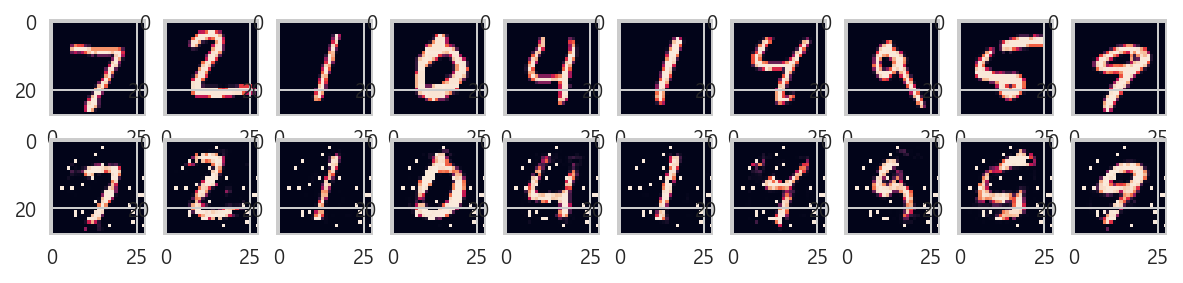

In [14]:
# Autoencoder 오토인코더 reconstruction
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

print("getting mnist data..", end ="")
mnist = input_data.read_data_sets("D:/mnist/data/", one_hot=True)
print("done!")

# 학습에 필요한 설정값 정의!

learning_rate = 0.02
training_epochs = 50
batch_size = 512
display_step = 1      # 손실함수 출력 주기
examples_to_show = 10 # 보여줄 이미지 개수
input_size = 784      #28*28
hidden1_size = 256
hidden2_size = 128

# 오토인코더는 비지도학습 == Y가 필요엄슴
x = tf.placeholder(tf.float32, shape=[None, input_size])

#구조 정의
def build_autoencoder(x):
    W1 = tf.Variable(tf.random_normal(shape=[input_size, hidden1_size]))
    b1 = tf.Variable(tf.random_normal(shape=[hidden1_size]))
    H1_output = tf.nn.sigmoid(tf.matmul(x,W1) + b1)
    W2 = tf.Variable(tf.random_normal(shape=[hidden1_size, hidden2_size]))
    b2 = tf.Variable(tf.random_normal(shape=[hidden2_size]))
    H2_output = tf.nn.sigmoid(tf.matmul(H1_output,W2) + b2)
    
    # 디코딩!
    W3 = tf.Variable(tf.random_normal(shape=[hidden2_size, hidden1_size]))
    b3 = tf.Variable(tf.random_normal(shape=[hidden1_size]))
    H3_output = tf.nn.sigmoid(tf.matmul(H2_output,W3) + b3)
    W4 = tf.Variable(tf.random_normal(shape=[hidden1_size, input_size]))
    b4 = tf.Variable(tf.random_normal(shape=[input_size]))
    reconstructed_x = tf.nn.sigmoid(tf.matmul(H3_output,W4) + b4)
    
    return reconstructed_x

y_pred = build_autoencoder(x)
# 타겟데이터는 인풋데이터와 같다.
y_true = x

loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2)) # MSE임
train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

print("======== Session start! ========")

config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.4 # GPU메모리 적용 % 설정

with tf.Session(config=config) as sess:
    # 변수 초기값 할당
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs):
        
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, current_loss = sess.run([train_step, loss], feed_dict={x:batch_xs})
        if epoch % display_step == 0:
            print("반복(Epoch): %d, 손실 함수(Loss): %f" % ((epoch+1), current_loss))
    
    reconstructed_result = sess.run(y_pred, feed_dict={x:mnist.test.images[:examples_to_show]})
    f, a = plt.subplots(2,10, figsize=(10,2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(reconstructed_result[i],(28,28)))
    f.savefig('reconstructed_mnist_image.png') # reconstruction 결과를 png로 저장합니다.
    clear_output()
    f.show()
    plt.draw()
#     plt.waitforbuttonpress()



In [7]:
# 기초...softmax regression
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

print("getting mnist data..", end ="")
mnist = input_data.read_data_sets("D:/mnist/data/", one_hot=True)
print("done!")

# with tf.device('/cpu:0'):
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])

W = tf.Variable(tf.zeros(shape=[784, 10]))
b = tf.Variable(tf.zeros(shape=[10]))

logits = tf.matmul(x, W) +b
y_pred = tf.nn.softmax(logits)

# cross-entropy 손실 함수와 옵티마이저를 정의합니다.
# loss = tf.reduce_mean(-tf.reduce_sum(y*tf.log(y_pred), reduction_indices=[1]))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))  # tf.nn.softmax_cross_entropy_with_logits API를 이용한 구현
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

print("======== Session start! ========")

config = tf.ConfigProto(log_device_placement=True)
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4 # GPU메모리 적용 % 설정

sess = tf.Session(config=config) # 자동 디바이스 로깅 == GPU알아서 찾아가지고 적용시킴
sess.run(tf.global_variables_initializer())

for i in range(1000):
    print("epoch : ", i , end=" --- \r")
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
    
print("")
correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("정확도(Accuracy): %f"%sess.run(accuracy, feed_dict={x:mnist.test.images, y:mnist.test.labels}))

getting mnist data..Extracting D:/mnist/data/train-images-idx3-ubyte.gz
Extracting D:/mnist/data/train-labels-idx1-ubyte.gz
Extracting D:/mnist/data/t10k-images-idx3-ubyte.gz
Extracting D:/mnist/data/t10k-labels-idx1-ubyte.gz
done!
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

======== Session start! ========
epoch :  999 --- 352 ---  --- 825 --- 
정확도(Accuracy): 0.919100


In [19]:
sess.close()